In [1]:
import os
import re
import json
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import tifffile
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [137]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
region_dir = project_dir / 'analysis' / 'region_characterization'
fig_dir = region_dir / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
results_dir = region_dir / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

In [7]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
case_order = [
    'HT206B1',
    'HT268B1',
    'HT339B2-H1',
    'HT397B1',
    'HT565B1-H2',
    'HT704B1',
    'HT891Z1',
    'HT913Z1',
    'S18-5591-C8',
    'S18-9906',
]

In [15]:
fps = sorted(utils.listfiles(region_dir, regex=r'.txt.gz$'))

sid_to_data = {}
dtype_to_df = {}
for fp in fps:
    name = fp.split('/')[-1]
    sid = re.sub(r'^(.*)_regions.txt.gz$', r'\1', name)
    print(sid)
    case = re.sub(r'^(.*)-U[0-9]+$', r'\1', sid)

    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)

    imaris_dir = project_dir / case / 'imaris' / 'rois'
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
    
    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    dti = sid_to_dtype_ident[sid]
    channels = sid_to_channels[sid]
    dtype = dtype_ident_to_dtype[dti]

    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['case'] = case
    df['sid'] = sid
    df['label'] = df.index.to_list()
    df['dtype'] = dtype
    df['dtype_ident'] = dti

    if case in [
        'HT891Z1',
        'HT913Z1',
        'S18-5591-C8',
        'S18-9906'
    ]:
        df['disease'] = 'prad'
    else:
        df['disease'] = 'brca'
    
    df.index = [f'{sid}_{x}' for x in df.index.to_list()]
    
    sid_to_data[sid] = {
        'df': df,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'channels': channels
    }

    if dtype not in dtype_to_df:
        dtype_to_df[dtype] = []
    dtype_to_df[dtype].append(df)

dtype_to_df = {k:pd.concat(v) for k, v in dtype_to_df.items()}

HT206B1-U10
HT206B1-U13
HT206B1-U16
HT206B1-U17
HT206B1-U18
HT206B1-U1
HT206B1-U21
HT206B1-U24
HT206B1-U2
HT206B1-U5
HT206B1-U8
HT206B1-U9
HT339B2-H1-U2
HT397B1-U12
HT397B1-U22
HT397B1-U2
HT397B1-U31
HT565B1-H2-U2
HT704B1-U11
HT704B1-U14
HT704B1-U17
HT704B1-U19
HT704B1-U1
HT704B1-U22
HT704B1-U26
HT704B1-U27
HT704B1-U2
HT704B1-U33
HT704B1-U35
HT704B1-U41
HT704B1-U43
HT704B1-U47
HT704B1-U50
HT704B1-U51
HT704B1-U53
HT704B1-U56
HT704B1-U60
HT704B1-U68
HT704B1-U76
HT704B1-U82
HT704B1-U85
HT704B1-U91
HT891Z1-U103
HT891Z1-U104
HT891Z1-U108
HT891Z1-U109
HT891Z1-U110
HT891Z1-U111
HT891Z1-U113
HT891Z1-U14
HT891Z1-U1
HT891Z1-U21
HT891Z1-U2
HT891Z1-U31
HT891Z1-U32
HT891Z1-U33
HT891Z1-U40
HT891Z1-U41
HT891Z1-U43
HT891Z1-U44
HT891Z1-U45
HT891Z1-U46
HT891Z1-U58
HT891Z1-U59
HT891Z1-U69
HT891Z1-U79
HT891Z1-U81
HT891Z1-U93
HT891Z1-U94
HT913Z1-U101
HT913Z1-U102
HT913Z1-U111
HT913Z1-U11
HT913Z1-U121
HT913Z1-U125
HT913Z1-U12
HT913Z1-U1
HT913Z1-U21
HT913Z1-U22
HT913Z1-U2
HT913Z1-U33
HT913Z1-U34
HT913Z1-U35


In [17]:
for dtype, df in dtype_to_df.items():
    print(dtype, df.shape)

multiplex (38841, 348)
xenium (31915, 15870)
cosmx (3460, 3138)
vishd (2341, 54261)


In [ ]:
df

In [22]:
dtype = 'xenium'
disease = 'prad'

channel = 'boundary_KRT5'


In [66]:
from typing import Iterable

In [78]:
grouped = None
corr_df = None
def get_correlation_df(dtype, disease, channel, root='region'):
    df = dtype_to_df[dtype]
    df = df[df['disease']==disease]

    cols = [c for c in df.columns if f'{root}_' in c if c != channel]
    data = []
    for col in cols:
        m = ~pd.isnull(df[col]) & ~pd.isnull(df[channel])
        source = df[[channel, col, 'sid']][m]
        for sid in sorted(set(source['sid'])):
            f = source[source['sid']==sid]
            xs = [x if not isinstance(x, Iterable) else x[0] for x in f[channel]]
            ys = [x if not isinstance(x, Iterable) else x[0] for x in f[col]]
            r = scipy.stats.pearsonr(xs, ys)
            
            data.append([sid, col, r.correlation, r.pvalue])
    corr_df = pd.DataFrame(data=data, columns=['sid', 'feature', 'correlation', 'pvalue'])

    grouped = corr_df[['feature', 'correlation', 'pvalue']].groupby('feature').mean()
    grouped[grouped['pvalue'] < .05]
    grouped = grouped.sort_values('correlation')

    return grouped


In [79]:
corr_dfs = {}
dtype_to_channel = {
    'multiplex': 'boundary_ck5',
    'xenium': 'boundary_KRT5',
    'cosmx': 'boundary_KRT5',
    'vishd': 'boundary_KRT5',
}
roots = ['region', 'boundary', 'tme']
for dtype in dtype_to_df.keys():
    channel = dtype_to_channel[dtype]
    for disease in ['brca', 'prad']:
        for root in roots:
            key = f'{disease}_{dtype}_{root}'
            print(key)
            corr_dfs[key] = get_correlation_df(dtype, disease, channel, root=root)

brca_multiplex_region


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_multiplex_boundary


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_multiplex_tme


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_multiplex_region


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_multiplex_boundary


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_multiplex_tme


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_xenium_region


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_xenium_boundary


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_xenium_tme


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_xenium_region


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_xenium_boundary


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_xenium_tme


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_cosmx_region


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)


brca_cosmx_boundary


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)


brca_cosmx_tme


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)


prad_cosmx_region
prad_cosmx_boundary
prad_cosmx_tme
brca_vishd_region


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_vishd_boundary


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

brca_vishd_tme


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_vishd_region


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_vishd_boundary


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

prad_vishd_tme


/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)
/tmp/ipykernel_1849449/3349799542.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.sta

In [80]:
corr_dfs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [134]:
from matplotlib import colors
def plot_corrs(corr_dfs, n=20, exclude=('celltypes', 'nbhd', 'myoepithelial', 'epithelial'), include=None, cmap='PiYG'):
    diseases = ['brca', 'prad']
    dtypes = ['xenium', 'cosmx', 'vishd']
    idents = ['region', 'tme']
    
    tups = [(ident, dtype) for ident in idents for dtype in dtypes]
    fig, axs = plt.subplots(nrows=len(keys) // 2, ncols=2)
    for i, disease in enumerate(diseases):
        for j, dtype in enumerate(dtypes):
            for k, ident in enumerate(idents):
                ax = axs[tups.index((ident, dtype)), i]
                df = corr_dfs[f'{disease}_{dtype}_{ident}']

                if exclude is not None:
                    idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
                elif include is not None:
                    idxs = [i for i in df.index.to_list() if len([x for x in include if x in i])]
                else:
                    raise RuntimeError('specify exclude or include')
                
                source = df.loc[idxs]
                source = source[~pd.isnull(source['correlation'])]
                if source.shape[0]:
                    if n * 2 < source.shape[0]:
                        source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                    source = source.sort_values('correlation', ascending=False)
                    source.index = [c.replace('region_', '').replace('tme_', '') for c in source.index.to_list()]
            
                    
                    divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
                    
                    sns.heatmap(source[['correlation']].T, cmap=cmap, norm=divnorm, xticklabels=True, ax=ax)
        
                    ax.set_ylabel(f'{disease}_{dtype}_{ident}', rotation=90)
                    ax.set_xlabel('')
                    ax.set_yticks([])
    
                    for x in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                        x.set_fontsize(2)
                    ax.tick_params(length=0)
                else:
                    ax.axis('off')
                

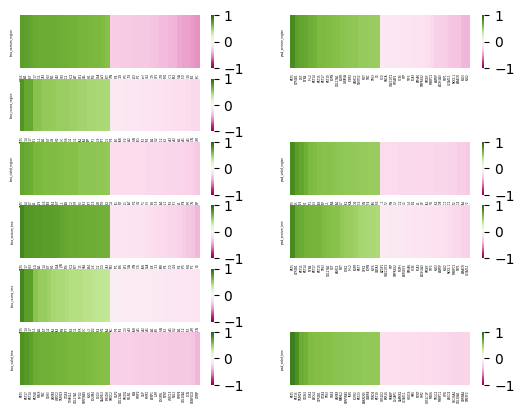

In [138]:
plot_corrs(corr_dfs, n=20)
plt.savefig(fig_dir / f'region_basal_gene_corrs.svg')

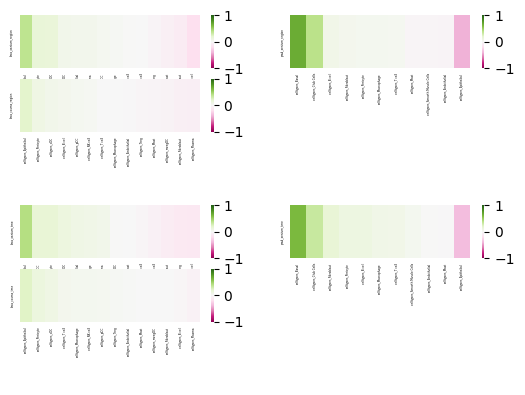

In [139]:
plot_corrs(corr_dfs, n=20, exclude=None, include=('celltypes',))
plt.savefig(fig_dir / f'region_basal_celltype_corrs.svg')